In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Pressão de vapor

In [2]:

pressao_vapor_perry = pd.read_csv("pressao_vapor.csv")

def calc_pressao_vapor(compound: str):
    row_compound = pressao_vapor_perry[pressao_vapor_perry['Name'] == compound]
    C1 = row_compound['C1'].iloc[0]
    C2 = row_compound['C2'].iloc[0]
    C3 = row_compound['C3'].iloc[0]
    C4 = row_compound['C4'].iloc[0]
    C5 = row_compound['C5'].iloc[0]
    Tmin =row_compound['Tmin'].iloc[0]
    Tmax =row_compound['Tmax'].iloc[0]
    T_range = np.linspace(Tmin, Tmax, 2000)
    pressao_vapor = []
    for T in T_range:
        pressao_vapor.append(np.exp(C1 + C2/T + C3*np.log(T) + C4*(T**C5)))
    return T_range, pressao_vapor


## Densidade e volume molar

In [3]:
densidade_molar_perry = pd.read_csv("densidade_molar.csv")

def calc_density(compound: str):
    row_compound = densidade_molar_perry[densidade_molar_perry['Name'] == compound]
    C1 = row_compound['C1'].iloc[0]
    C2 = row_compound['C2'].iloc[0]
    C3 = row_compound['C3'].iloc[0]
    C4 = row_compound['C4'].iloc[0]
    Tmin =row_compound['Tmin'].iloc[0]
    Tmax =row_compound['Tmax'].iloc[0]
    T_range = np.linspace(Tmin, Tmax, 2000)
    densidade_molar = []
    volume_molar = []
    for T in T_range:
        if compound == 'Water' or compound == 'o-Terphenyl':
            densidade_molar.append(C1 + C2*T + C3*(T**2) + C4*(T**3))
            volume_molar.append(1/(C1 + C2*T + C3*(T**2) + C4*(T**3)))
        else:
            densidade_molar.append(C1/(C2**(1+(1-T/C3)**C4)))
            volume_molar.append(1/(C1/(C2**(1+(1-T/C3)**C4))))
    return T_range, densidade_molar, volume_molar


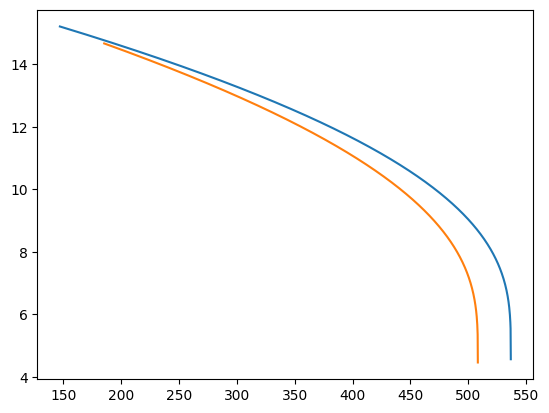

In [7]:
x1,d1,v1 = calc_density('1-Propanol')
x2,d2,v2 = calc_density('2-Propanol')
plt.plot(x1,d1)
plt.plot(x2,d2)

In [24]:
def grafico_pressao_vapor(T_range, pressao_vapor, compound):
    plt.plot(T_range, pressao_vapor)
    plt.xlabel('Temperatura (K)')
    plt.ylabel('Pressão de Vapor (Pa)')
    plt.title('Pressão de Vapor de ' + compound)
    plt.show()

In [33]:
x1,y1 = calc_pressao_vapor('Ethanol')
x2,y2 = calc_pressao_vapor('Water')
x3,y3 = calc_pressao_vapor('Acetone')

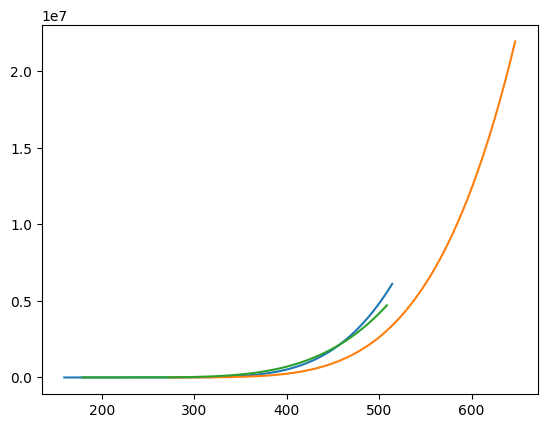

In [34]:
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)